# Carregamento dos dados

In [84]:
import pandas as pd

# Carregando os dados do arquivo CSV pré-processado em um DataFrame do pandas
comentarios = pd.read_csv('../Data/content_pre_processado.csv')

# Exibindo as primeiras 5 linhas do DataFrame para verificação
comentarios.head(5)

,reviewId,app_name,content,sentiment_polarity,sentiment
0,01e23c15-44bf-46b7-b280-40e880d9d49b,Shopee,sopre razoável apesar fácil utilizar apresenta...,positive,sadness
1,df40ba7c-075d-48dc-b798-21466dfb41d6,Shopee,otimizar fácil visualizar produto pedido rastr...,positive,sadness
2,59490b23-b17b-4bba-855b-b5053dadc0db,Shopee,prático fácil entender vendedor mandar produto...,positive,sadness
3,48fd8168-1e42-4475-9a99-935c2fd48769,Shopee,aplicativo chatear fato pesquisar produto colo...,positive,sadness
4,f4e1468b-6d97-4f1a-927d-1afee2bfbe75,Shopee,ter dificuldade pagamento cartão crédito compr...,negative,disgust


# Extração da features (representação de texto em formato vetorial)

<p style="color:green">A seguir, faremos a instanciação do método que fará a representação do texto usando Doc2Vec.</p> 

In [85]:
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import nltk

# Transformando os comentários em um formato adequado para o modelo Doc2Vec
# TaggedDocument: Estrutura que associa um documento (lista de palavras) a uma etiqueta (tag)
# Cada comentário é tokenizado e associado a um índice único
comentarios_tagged = [TaggedDocument(words=nltk.word_tokenize(text), tags=[str(i)]) 
                      for i, text in enumerate(comentarios['content'])]

# Criando e treinando o modelo Doc2Vec
# vector_size=100: Tamanho dos vetores de saída
# window=5: Tamanho da janela de contexto
# min_count=2: Ignorar palavras que aparecem menos de 2 vezes
# workers=4: Número de threads para treinamento
# epochs=40: Número de épocas para treinamento
doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=40)
doc2vec_model.build_vocab(comentarios_tagged) # Construindo o vocabulário do modelo
doc2vec_model.train(comentarios_tagged, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs) # Treinando o modelo

# Gerando vetores Doc2Vec para cada comentário
# infer_vector: Gera um vetor para um novo documento com base no modelo treinado
comentarios_vectors = [doc2vec_model.infer_vector(nltk.word_tokenize(text)) for text in comentarios['content']]

In [86]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Convertendo a lista de vetores Doc2Vec em uma matriz NumPy
# X será uma matriz onde cada linha representa um vetor de documento
X = np.array(comentarios_vectors)

# Separando as variáveis alvo (rótulos) para polaridade e sentimento
# y_polarity: Rótulos de polaridade do sentimento (positivo, negativo ou neutro)
# y_sentiment: Rótulos de sentimento (Happiness, Surprise, Sadness, Neutral, Fear, Disgust, Anger)
y_polarity = comentarios['sentiment_polarity'].values
y_sentiment = comentarios['sentiment'].values

<p style="color:green">Codificação de sentiment e polarity</p> 

In [87]:
# Codificando as classes de polaridade de string para números inteiros
# LabelEncoder converte as categorias de texto em números inteiros
le_polarity = LabelEncoder()
y_polarity_encoded = le_polarity.fit_transform(y_polarity)

# Convertendo os rótulos inteiros para uma codificação one-hot
# to_categorical transforma os rótulos inteiros em vetores binários
y_polarity_categorical = to_categorical(y_polarity_encoded)

# Codificando as classes de sentimento de string para números inteiros
le_sentiment = LabelEncoder()
y_sentiment_encoded = le_sentiment.fit_transform(y_sentiment)

# Convertendo os rótulos inteiros para uma codificação one-hot
y_sentiment_categorical = to_categorical(y_sentiment_encoded)

# Treinamento e teste

In [88]:
# Dividindo os dados para a tarefa de classificação de polaridade do sentimento
# train_test_split: Divide o conjunto de dados em conjuntos de treino e teste
# test_size=0.2: 20% dos dados serão usados para teste e 80% para treino
# random_state=42: Define uma semente para garantir a reprodutibilidade
X_train_polarity, X_test_polarity, y_train_polarity, y_test_polarity = train_test_split(X, y_polarity_categorical, test_size=0.2, random_state=42)

# Dividindo os dados para a tarefa de classificação de sentimento
# test_size=0.2: 20% dos dados serão usados para teste e 80% para treino
# random_state=42: Define uma semente para garantir a reprodutibilidade
X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(X, y_sentiment_categorical, test_size=0.2, random_state=42)


In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

def create_model(input_shape, n_classes):
    # Criando um modelo sequencial com Keras
    model = Sequential([
        Input(shape=input_shape), # Camada de entrada com a forma dos dados de entrada
        Dense(128, activation='relu'), # Camada densa com 128 neurônios e ativação ReLU
        Dropout(0.5), # Camada de Dropout para regularização, evita overfitting
        Dense(64, activation='relu'), # Camada densa com 64 neurônios e ativação ReLU
        Dense(n_classes, activation='softmax') # Camada de saída com número de classes, ativação softmax para problemas de classificação multiclasse
    ])
    # Compilando o modelo
    # optimizer='adam': Otimizador Adam para ajustar os pesos do modelo
    # loss='categorical_crossentropy': Função de perda para problemas de classificação multiclasse
    # metrics=['accuracy']: Métrica para avaliar o desempenho do modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Criar o modelo para a tarefa de classificação de sentimento
# input_shape: Forma da entrada do modelo, que corresponde ao número de características dos vetores Doc2Vec
# n_classes: Número de classes na tarefa de classificação de sentimento
model_sentiment = create_model((X_train_sentiment.shape[1],), y_sentiment_categorical.shape[1])

# Criar o modelo para a tarefa de classificação de polaridade
# input_shape: Forma da entrada do modelo, que corresponde ao número de características dos vetores Doc2Vec
# n_classes: Número de classes na tarefa de classificação de polaridade
model_polarity = create_model((X_train_polarity.shape[1],), y_polarity_categorical.shape[1])

In [90]:
# Treinando o modelo para a tarefa de classificação de sentimento
# epochs=10: Número de épocas para treinar o modelo (10 passes completos pelos dados de treinamento)
# batch_size=32: Número de amostras por atualização do gradiente
# validation_data=(X_test_sentiment, y_test_sentiment): Dados de validação usados para monitorar o desempenho do modelo durante o treinamento
model_sentiment.fit(X_train_sentiment, y_train_sentiment, epochs=10, batch_size=32, validation_data=(X_test_sentiment, y_test_sentiment))

# Avaliando o modelo treinado usando os dados de teste
# O método evaluate retorna a perda e a precisão do modelo nos dados de teste
loss, accuracy = model_sentiment.evaluate(X_test_sentiment, y_test_sentiment)
# Imprimindo a precisão do modelo formatada como porcentagem
print(f'Acurácia do modelo para sentiment: {accuracy*100:.2f}%')

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2975 - loss: 1.7143 - val_accuracy: 0.4651 - val_loss: 1.2891
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4795 - loss: 1.2804 - val_accuracy: 0.5116 - val_loss: 1.1875
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5408 - loss: 1.1645 - val_accuracy: 0.5365 - val_loss: 1.1561
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5553 - loss: 1.1151 - val_accuracy: 0.5349 - val_loss: 1.1500
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5633 - loss: 1.0992 - val_accuracy: 0.5349 - val_loss: 1.1557
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5717 - loss: 1.0794 - val_accuracy: 0.5332 - val_loss: 1.1624
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5944 - loss: 1.0514 - val_accuracy: 0.5415 - val_loss: 1.1502
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5868 - loss: 1.0480 - val_accuracy: 0.5365 - val_loss:

In [91]:
from sklearn.metrics import classification_report
import numpy as np

# Gerar previsões para o conjunto de teste
# model_sentiment.predict retorna as probabilidades previstas para cada classe
# np.argmax é usado para converter essas probabilidades em classes, selecionando a classe com a maior probabilidade
y_pred_sentiment = model_sentiment.predict(X_test_sentiment)
y_pred_sentiment = np.argmax(y_pred_sentiment, axis=1)  # Convertendo probabilidades em classes

# Convertendo os rótulos codificados de volta para os rótulos originais
# np.argmax é usado para converter as previsões one-hot de volta para índices de classes
# le_sentiment.inverse_transform converte os índices de volta para os rótulos de texto originais
y_test_sentiment_original = le_sentiment.inverse_transform(np.argmax(y_test_sentiment, axis=1))
y_pred_sentiment_original = le_sentiment.inverse_transform(y_pred_sentiment)

# Gerar o relatório de classificação
# classification_report fornece métricas de desempenho como precisão, recall e F1-score
print("Classification Report for Sentiment:")
print(classification_report(y_test_sentiment_original, y_pred_sentiment_original))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report for Sentiment:
              precision    recall  f1-score   support

       anger       0.53      0.63      0.58       158
     disgust       0.54      0.42      0.47       179
        fear       0.00      0.00      0.00         7
   happiness       0.55      0.46      0.50        68
     neutral       0.00      0.00      0.00        14
     sadness       0.52      0.63      0.57       175
    surprise       0.00      0.00      0.00         1

    accuracy                           0.53       602
   macro avg       0.31      0.31      0.30       602
weighted avg       0.51      0.53      0.51       602



c:\Users\dougl\OneDrive\Desktop\Mineracao_Textos\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dougl\OneDrive\Desktop\Mineracao_Textos\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dougl\OneDrive\Desktop\Mineracao_Textos\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step


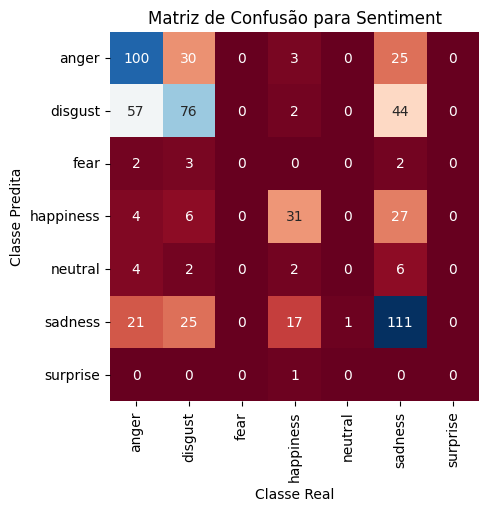

In [92]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Gerar previsões para o conjunto de teste
# model_sentiment.predict retorna as probabilidades previstas para cada classe
# np.argmax é usado para converter essas probabilidades em classes, selecionando a classe com a maior probabilidade
y_pred_sentiment = model_sentiment.predict(X_test_sentiment)
y_pred_sentiment = np.argmax(y_pred_sentiment, axis=1)  # Convertendo probabilidades em classes

# Obtendo os rótulos únicos para o sentimento, que serão usados nos eixos da matriz de confusão
# le_sentiment.classes_ fornece os rótulos originais das classes
sentiment_labels = le_sentiment.classes_

# Calculando a matriz de confusão
# confusion_matrix compara as previsões com os rótulos reais
# np.argmax é usado para converter as previsões one-hot de volta para índices de classes
# labels=range(len(sentiment_labels)) garante que todos os rótulos possíveis sejam incluídos na matriz
cm_sentiment = confusion_matrix(np.argmax(y_test_sentiment, axis=1), y_pred_sentiment, labels=range(len(sentiment_labels)))

# Criando um gráfico da matriz de confusão usando seaborn
# sns.heatmap cria um mapa de calor da matriz de confusão
sns.heatmap(cm_sentiment, square=True, annot=True, fmt='d', cmap='RdBu', cbar=False, 
            xticklabels=sentiment_labels,
            yticklabels=sentiment_labels)

plt.xlabel("Classe Real")    # Rótulo do eixo x
plt.ylabel("Classe Predita") # Rótulo do eixo y
plt.title("Matriz de Confusão para Sentiment") # Título do gráfico
plt.show() # Exibindo o gráfico


In [93]:
# Treinar o modelo para a tarefa de classificação de polaridade
# model_polarity.fit treina o modelo com os dados de treinamento para 'sentiment_polarity'
# epochs=10: Número de épocas para treinar o modelo (10 passes completos pelos dados de treinamento)
# batch_size=32: Número de amostras por atualização do gradiente
# validation_data=(X_test_polarity, y_test_polarity): Dados de validação usados para monitorar o desempenho do modelo durante o treinamento
model_polarity.fit(X_train_polarity, y_train_polarity, epochs=10, batch_size=32, validation_data=(X_test_polarity, y_test_polarity))

# Avaliar o modelo treinado usando os dados de teste
# O método evaluate retorna a perda e a precisão do modelo nos dados de teste
loss, accuracy = model_polarity.evaluate(X_test_polarity, y_test_polarity)
# Imprimindo a precisão do modelo formatada como porcentagem
print(f'Acurácia do modelo para sentiment_polarity: {accuracy*100:.2f}%')

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5627 - loss: 0.8685 - val_accuracy: 0.7409 - val_loss: 0.5930
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7614 - loss: 0.5799 - val_accuracy: 0.7824 - val_loss: 0.5650
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7686 - loss: 0.5556 - val_accuracy: 0.7741 - val_loss: 0.5726
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7921 - loss: 0.5151 - val_accuracy: 0.7724 - val_loss: 0.5772
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7884 - loss: 0.5173 - val_accuracy: 0.7807 - val_loss: 0.5750
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7920 - loss: 0.5073 - val_accuracy: 0.7807 - val_loss: 0.5706
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8091 - loss: 0.4786 - val_accuracy: 0.7691 - val_loss: 0.5907
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7914 - loss: 0.4898 - val_accuracy: 0.7757 - val_loss:

In [94]:
from sklearn.metrics import classification_report
import numpy as np

# Gerar previsões para o conjunto de teste
# model_polarity.predict retorna as probabilidades previstas para cada classe
# np.argmax é usado para converter essas probabilidades em classes, selecionando a classe com a maior probabilidade
y_pred_polarity = model_polarity.predict(X_test_polarity)
y_pred_polarity = np.argmax(y_pred_polarity, axis=1)  # Convertendo probabilidades em classes

# Convertendo rótulos codificados de volta para os rótulos originais
# np.argmax é usado para converter as previsões one-hot de volta para índices de classes
# le_polarity.inverse_transform converte os índices de volta para os rótulos de texto originais
y_test_polarity_original = le_polarity.inverse_transform(np.argmax(y_test_polarity, axis=1))
y_pred_polarity_original = le_polarity.inverse_transform(y_pred_polarity)

# Gerar o relatório de classificação
print("Classification Report for Sentiment Polarity:")
print(classification_report(y_test_polarity_original, y_pred_polarity_original))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report for Sentiment Polarity:
              precision    recall  f1-score   support

    negative       0.78      0.84      0.81       344
     neutral       0.00      0.00      0.00        14
    positive       0.73      0.69      0.71       244

    accuracy                           0.76       602
   macro avg       0.50      0.51      0.51       602
weighted avg       0.74      0.76      0.75       602



c:\Users\dougl\OneDrive\Desktop\Mineracao_Textos\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dougl\OneDrive\Desktop\Mineracao_Textos\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dougl\OneDrive\Desktop\Mineracao_Textos\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step


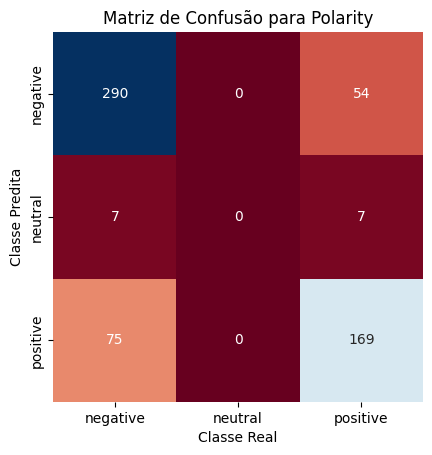

In [95]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Gerar previsões para o conjunto de teste
# model_polarity.predict retorna as probabilidades previstas para cada classe
# np.argmax é usado para converter essas probabilidades em classes, selecionando a classe com a maior probabilidade
y_pred_polarity = model_polarity.predict(X_test_polarity)
y_pred_polarity = np.argmax(y_pred_polarity, axis=1)  # Convertendo probabilidades em classes

# Obtendo os rótulos únicos para polaridade, que serão usados nos eixos da matriz de confusão
# le_polarity.classes_ fornece os rótulos originais das classes
polarity_labels = le_polarity.classes_

# Calculando a matriz de confusão
# confusion_matrix compara as previsões com os rótulos reais
# np.argmax é usado para converter os rótulos one-hot de volta para índices de classes
# labels=range(len(polarity_labels)) garante que todos os rótulos possíveis sejam incluídos na matriz
cm_polarity = confusion_matrix(np.argmax(y_test_polarity, axis=1), y_pred_polarity, labels=range(len(polarity_labels)))

# Criando um gráfico da matriz de confusão usando seaborn
# sns.heatmap cria um mapa de calor da matriz de confusão
sns.heatmap(cm_polarity, square=True, annot=True, fmt='d', cmap='RdBu', cbar=False, 
            xticklabels=polarity_labels,
            yticklabels=polarity_labels)

plt.xlabel("Classe Real")    # Rótulo do eixo x
plt.ylabel("Classe Predita") # Rótulo do eixo y
plt.title("Matriz de Confusão para Polarity") # Título do gráfico
plt.show() # Exibindo o gráfico

# Usando comentários de teste

In [96]:
import pandas as pd

# Carregando os dados do arquivo CSV pré-processado em um DataFrame do pandas
comentarios_teste = pd.read_csv('../Data/teste_pre_processado.csv')

# Exibindo as primeiras 5 linhas do DataFrame para verificação
comentarios_teste.head(5)

,reviewId,app_name,content,sentiment_polarity,sentiment
0,a12345f6-78g9-1011-h121-314151617181,YouTube,interface Youtube ficar confusa recomendação b...,negative,anger
1,b23456g7-89h0-1122-i131-415161718192,Netflix,catálogo netflix bom qualidade streaming incon...,positive,happiness
2,c34567h8-90i1-1233-j141-516171819203,Spotify,experiência spotify incrível quantidade propag...,positive,sadness


In [97]:
import pandas as pd
import nltk
from gensim.models import Doc2Vec

# Verifica se o DataFrame contém a coluna 'content'
if 'content' not in comentarios_teste.columns:
    raise ValueError("O DataFrame não contém a coluna 'content'.")

# Tokenizar os textos do novo dataset
comentarios_teste['tokens'] = comentarios_teste['content'].apply(lambda x: nltk.word_tokenize(x.lower()))  # Tokenização e normalização para minúsculas

# Verifique se a coluna 'tokens' foi criada corretamente
print(comentarios_teste.head())


                               reviewId app_name  \
0  a12345f6-78g9-1011-h121-314151617181  YouTube   
1  b23456g7-89h0-1122-i131-415161718192  Netflix   
2  c34567h8-90i1-1233-j141-516171819203  Spotify   

                                             content sentiment_polarity  \
0  interface Youtube ficar confusa recomendação b...           negative   
1  catálogo netflix bom qualidade streaming incon...           positive   
2  experiência spotify incrível quantidade propag...           positive   

   sentiment                                             tokens  
0      anger  [interface, youtube, ficar, confusa, recomenda...  
1  happiness  [catálogo, netflix, bom, qualidade, streaming,...  
2    sadness  [experiência, spotify, incrível, quantidade, p...  


In [98]:
# Converter os textos tokenizados em vetores Doc2Vec
comentarios_teste_vectors = [doc2vec_model.infer_vector(tokens) for tokens in comentarios_teste['tokens']]

# Converter a lista de vetores Doc2Vec em uma matriz NumPy
X_teste = np.array(comentarios_teste_vectors)

In [99]:
# Fazer previsões com o modelo treinado
y_pred_sentiment_novos = model_sentiment.predict(X_teste)
# Obtém as probabilidades para cada classe

# Converter probabilidades em classes
y_pred_sentiment_novos_classes = np.argmax(y_pred_sentiment_novos, axis=1)
# Converte as probabilidades em classes

# Converter índices de classes para etiquetas originais
sentiment_labels_novos = le_sentiment.inverse_transform(y_pred_sentiment_novos_classes)
# Converte os índices das classes de volta para as etiquetas originais

# Adicionar as previsões ao DataFrame
comentarios_teste['sentiment_predito'] = sentiment_labels_novos

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [100]:
# Fazer previsões com o modelo treinado
y_pred_polarity_novos = model_polarity.predict(X_teste)
y_pred_polarity_novos_classes = np.argmax(y_pred_polarity_novos, axis=1)

# Converter índices de classes para as etiquetas originais
polarity_labels_novos = le_polarity.inverse_transform(y_pred_polarity_novos_classes)
comentarios_teste['polaridade_predita'] = polarity_labels_novos

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [101]:
# Exibir o DataFrame com as previsões
print(comentarios_teste[['content', 'sentiment_predito', 'polaridade_predita']])

                                             content sentiment_predito  \
0  interface Youtube ficar confusa recomendação b...         happiness   
1  catálogo netflix bom qualidade streaming incon...         happiness   
2  experiência spotify incrível quantidade propag...           sadness   

  polaridade_predita  
0           positive  
1           positive  
2           positive  


In [112]:
from sklearn.metrics import classification_report
import numpy as np

# Fazer previsões com o modelo de polaridade para o novo dataset
y_pred_polarity_novos = model_polarity.predict(X_teste)
y_pred_polarity_novos_classes = np.argmax(y_pred_polarity_novos, axis=1)  # Convertendo probabilidades em classes

# Fazer previsões com o modelo de sentimento para o novo dataset
y_pred_sentiment_novos = model_sentiment.predict(X_teste)
y_pred_sentiment_novos_classes = np.argmax(y_pred_sentiment_novos, axis=1)  # Convertendo probabilidades em classes

# Converter índices das classes preditas para etiquetas originais
sentiment_labels_novos = le_sentiment.inverse_transform(y_pred_sentiment_novos_classes)
polarity_labels_novos = le_polarity.inverse_transform(y_pred_polarity_novos_classes)

# Gerar o relatório de classificação para o novo dataset
print("Classification Report for Sentiment:")
print(classification_report(comentarios_teste['sentiment'], sentiment_labels_novos))

print("Classification Report for Polarity:")
print(classification_report(comentarios_teste['sentiment_polarity'], polarity_labels_novos))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Classification Report for Sentiment:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         1
   happiness       0.50      1.00      0.67         1
     sadness       1.00      1.00      1.00         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3

Classification Report for Polarity:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         1
    positive       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



c:\Users\dougl\OneDrive\Desktop\Mineracao_Textos\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dougl\OneDrive\Desktop\Mineracao_Textos\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dougl\OneDrive\Desktop\Mineracao_Textos\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif